In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer
from scipy.special import binom
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy.stats import jarque_bera
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics
import math
import scipy.stats as stats
import random
import itertools
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

In [26]:
def parse_base_mev(iv):
    '''
    Desc:
    Get base mev from list of lagged mevs
    
    input:
    iv: list (1d or 2d) of strings representing base mev with lags
    
    output:
    base_mev: list or unique base mevs
    lags: list of unique lags
    '''
    # confirm type is 2d list
    if type(iv[0]) == str:
        iv = [iv]
        
    output_mev = []
    output_lags = []
    for group_of_mevs in iv:
        for lagged_mev in group_of_mevs:
            # parse the base out
            parse = lagged_mev.split("_")
            if len(parse) != 2:
                print("Error: format for iv passed requires it to be lagged. issue with {}".format(lagged_mev))
                return
            if parse[0] not in output_mev:
                output_mev.append(parse[0])
            if int(parse[1][3:]) not in output_lags:
                output_lags.append(int(parse[1][3:]))
    return output_mev,output_lags
    
def get_lagged_vars(df,iv,lags,freq = "D"):
    '''
    Desc:
    Create new columns in df. These columns are just shifts of the original columns, and referred as 
    lagged variables.
    
    Parameters:
    df: pandas dataframe
    iv: list of column names from df. These are the independent variables
    lags: list of non-negative integers
    freq: frequency of the dattimeindex of df. default is "D"
    
    Output:
    updates df with new lagged variable columns and list of lagged variabls
    '''
    iv_wLags = list(iv)
    for v in iv:
        for l in lags:
            new_name = v + "_lag" + str(l)
            df[new_name] = df[v].shift(l, freq = freq)
    df.drop
    return df,iv_wLags

def powerset(iterable):
    '''
    Desc:
    Returns all subsets of an iterable excluding the emptyset
    
    Input:
    list of integers
    
    Output:
    Returns all subsets of an iterable excluding the emptyset
    '''
    s = list(iterable)
    return list(itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1)))[1:]

def get_columns_arima(iv, num_var_model = None, value = None):
    '''
    Desc:
    Provides the statistics of each model we want to capture. 
    
    Inputs:
    iv: list of independent variables 
    num_var_model: list of integers, where an integer a in num_var_model indicates that we consider models with
        a-many independent variables. Default is ALL, ie, [1,2,3,...,len(iv)]
        
    Output:
    returns the list of column names used to construct the output of testing all models
    '''
    if (num_var_model == None) or (type(num_var_model) == int):
        num_var_model = range(1,len(iv) + 1)
        
    # Get columns for arima terms
    ar_variables = []
    ar_coeff = []
    ar_pvals = []
    ma_variables = []
    ma_coeff = []
    ma_pvals = []
    if value != None:
        if type(value) == int:
            arima_indexer = value
        else:
            arima_indexer = max(value)
        for arima_index in range(1,1+arima_indexer):
            ar_coeff.append("ar_Coefficient_{}".format(str(arima_index)))
            ar_pvals.append("ar_PValue_{}".format(str(arima_index)))       
            ma_coeff.append("ma_Coefficient_{}".format(str(arima_index)))
            ma_pvals.append("ma_PValue_{}".format(str(arima_index)))  
        
    n = max(num_var_model)
    variables = []
    coeff = []
    pvals = []
    for i in range(n):
        variables.append("Variable_{}".format(str(i)))
        coeff.append("Coefficient_{}".format(str(i)))
        pvals.append("PValue_{}".format(str(i)))
    others = ['AIC','BIC','RMSE','Significant_Variables','ma_order','integrated_value','ar_order',
              'exog_id','BreuschPagan','jarque_bera','ljung_box']
    output_cols = variables + ar_variables + ma_variables + coeff + ar_coeff + ma_coeff + ['Coefficient_const'] + pvals + ['PValue_const'] + ar_pvals + ma_pvals + others
    return output_cols

def exhaustiveOrderComputation(df,iv,exog,dv,lags,value):
    '''
    Desc:
    Perform analysis for ARIMAX models for various orders
    
    Input:
    df: pandas dataframe
    iv: list of available independent variables
    exog: list (1d 2d) of lagged variables used as exogenous variables for the model
    dv: dependent variable
    lags: list of non-negative integers
    value: integer or list, loops through subsets of the list or range(integer)
    
    Output:
    Pandas datarfame that captures each ARIMAX model constructed and corresponding statistics of the models
    '''
    
    # prep dataframe with lagged variables and get list of mevs with lags
    df,iv_wlags = get_lagged_vars(df,iv,lags)
    df = df.dropna()
    
    # format iv input to be 2d
    if type(exog[0]) == str:
        exog = [exog]
    
    # formats value into list if given as integer
    if type(value) == int:
        value = range(1,value + 1)
        
    # Get list of subsets of the iterable value
    powerset_value = powerset(value)
        
    # Determine maximum number of exogenous variables passed in
    num_var_model = -1
    for group in exog:
        if len(group) > num_var_model:
            num_var_model = len(group)
    
    # Get columsn for output 
    output_cols = get_columns_arima(iv,num_var_model = num_var_model, value = value )
    
    # total models is the product of
        # 1. number of sets of exogenous variables
        # 2. number of orders (p,q) - powerset minus empty set for both p and q
        # 3. number for d - difference betwee static values of dv (length of value)
    total_models = len(exog)*((2**(max(value))-1)**2) * len(value)
    
    # prep output
    output = pd.DataFrame(columns = output_cols, index = range(total_models))

    #row index
    i = 0
    
    # go through all sets of iv's passed in
    for model_index, current_model_var in enumerate(exog):
        for p in powerset_value:
            for d in range(max(value)):
                for q in powerset_value:
                    # Train model
                    print("Total {} current {}".format(total_models,i), end = '\r')

                    output['ma_order'][i] = q 
                    output['integrated_value'][i] = d
                    output['ar_order'][i] = p

                    x = df[current_model_var]
                    x = sm.add_constant(x, prepend = False)
                    y = df[dv]
                    model = SARIMAX(y,exog = x, order = (p,d,q))
                    try:
                        results = model.fit(disp = False)

                        # populate output
                        output['exog_id'][i] = model_index

                        for cnt, v in enumerate(results.params.index[:-1]): # removed sigma squared
                            if v == 'const':
                                output['Coefficient_const'][i] = results.params[v]
                                output['PValue_const'][i] = results.pvalues[v]
                            elif 'ma.' in v:
                                numeric_part = v[4:]
                                output['ma_Coefficient_' + numeric_part][i] = results.params[v]
                                output['ma_PValue_' + numeric_part][i] = results.pvalues[v]
                            elif 'ar.' in v:
                                numeric_part = v[4:]
                                output['ar_Coefficient_' + numeric_part][i] = results.params[v]
                                output['ar_PValue_' + numeric_part][i] = results.pvalues[v]    
                            else:
                                # all exogenous variables are first, so cnt will work
                                output['Variable_' + str(cnt)][i] = v
                                output['Coefficient_' + str(cnt)][i] = results.params[v]
                                output['PValue_' + str(cnt)][i] = results.pvalues[v]

                        output['AIC'][i] = results.aic
                        output['BIC'][i] = results.bic
                        output['Significant_Variables'][i] = np.where(results.pvalues[:-1].max() < 0.05,
                                                                     'Pass','Fail')
                        output['BreuschPagan'][i] = sms.het_breuschpagan(results.resid, results.model.exog)[1]
                        output['jarque_bera'][i] = jarque_bera(results.resid)[1]
                        output['ljung_box'][i] = np.round(sm.stats.acorr_ljungbox(results.resid, lags=range(10,15), return_df=True)['lb_pvalue'].min(),6)
                    except:
                        output['exog_id'][i] = 'LinAlgError'
                    i += 1
    return output
    
    
    

In [27]:
# Read data
df = pd.read_csv('fred_data.csv', index_col = 'date')

# fill in missing days - linear interpolation
idx = pd.date_range(df.index.min(), df.index.max())
df.index = pd.DatetimeIndex(df.index)
df = df.reindex(idx).interpolate()

# Specify the independent variabls
iv = ['OVXCLS',
      'DCOILWTICO',
      'SP500',
      'T10YIE',
      'DBAA',
      'VIXCLS'
     ]

# Specifiy the lags
lags = [0,7,14]

# Exogenous variabls
exog = [['OVXCLS_lag0','DCOILWTICO_lag14','SP500_lag0','T10YIE_lag0','VIXCLS_lag14'],
        ['OVXCLS_lag0','DCOILWTICO_lag14','SP500_lag0','T10YIE_lag0']
       ]

# Provide value
value = 3

# Specify the dependent variabl
dv = 'CBBTCUSD'

In [28]:
# Compute pool of models
candidates = exhaustiveOrderComputation(df,iv,exog,dv,lags,value)

In [33]:
# filter for models that satisfy some properties
filtered = candidates[
    (candidates.Significant_Variables == 'Pass') & # this will exclude any models that failed to compute due to LU Decomp issues
    (candidates.jarque_bera < 0.05) & # goodness of fit, ~ normal 
    (candidates.ljung_box > 0.05) # ljung_box applied with lags 10 through 15
]

# sort by AIC and exog_id
filtered.sort_values(['exog_id','AIC'], ascending = True, inplace = True)

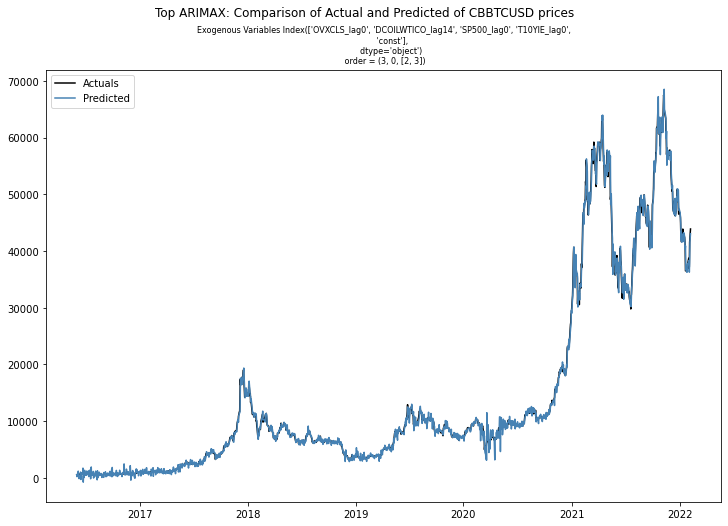

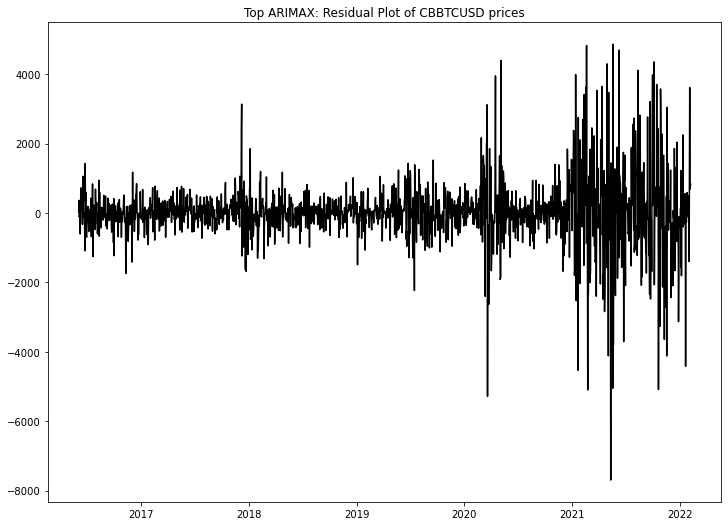

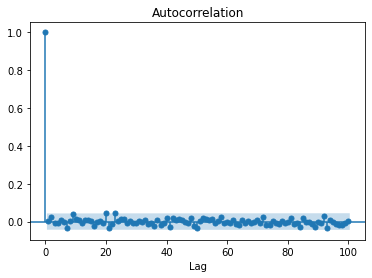

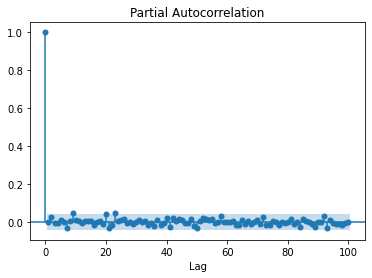

In [82]:
tmp = df.copy()
tmp.dropna(inplace = True)
x = tmp[['OVXCLS_lag0','DCOILWTICO_lag14','SP500_lag0','T10YIE_lag0']]
x = sm.add_constant(x, prepend = False)
y = tmp[dv]
order = (3,0,[2,3])
model = SARIMAX(y,exog = x, order = order)
res = model.fit(disp = False)
pred = res.predict(exog = x)

fig, axs = plt.subplots(1,1,figsize = (10,7.2), constrained_layout = True)
plt.suptitle('Top ARIMAX: Comparison of Actual and Predicted of {} prices'.format(dv))
plt.title('Exogenous Variables {}\n order = {}'.format(x.columns,order),
          fontsize = 8
         )
plt.plot(y[1:], color = 'black')
plt.plot(pred[1:], color = 'steelblue')
plt.legend(["Actuals","Predicted"], loc = 'upper left')

fig, axs = plt.subplots(1,1,figsize = (10,7.2), constrained_layout = True)
plt.title('Top ARIMAX: Residual Plot of {} prices'.format(dv))
plt.plot(res.resid[1:], color = 'black')

fig = sm.graphics.tsa.plot_acf(res.resid, alpha = 0.05, lags = 100)
plt.xlabel('Lag')
plt.show()

fig = sm.graphics.tsa.plot_pacf(res.resid, alpha = 0.05, lags = 100)
plt.xlabel('Lag')

plt.show()

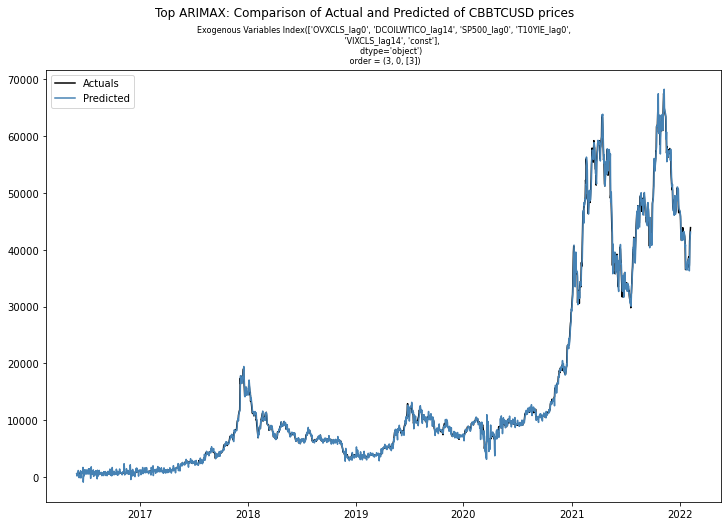

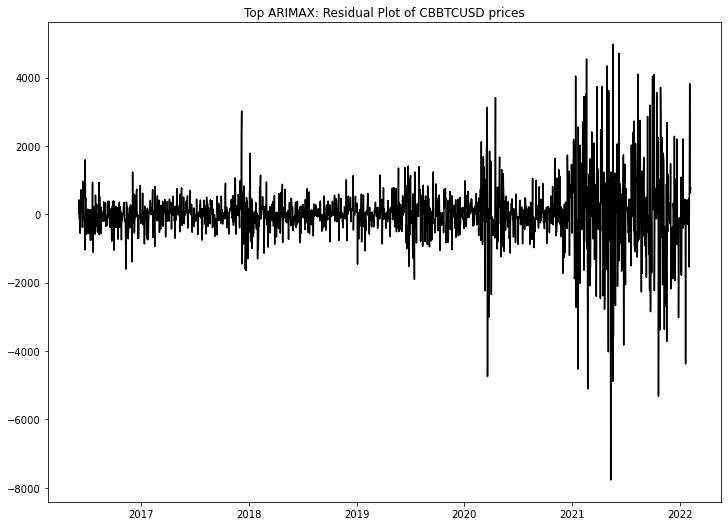

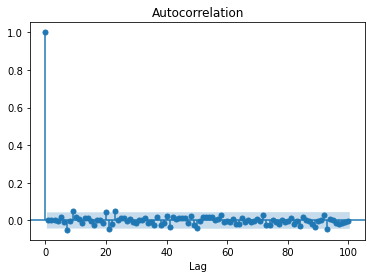

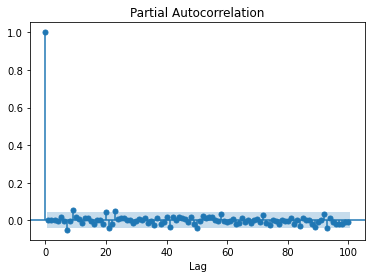

In [83]:
tmp = df.copy()
tmp.dropna(inplace = True)
x = tmp[['OVXCLS_lag0','DCOILWTICO_lag14','SP500_lag0','T10YIE_lag0','VIXCLS_lag14']]
x = sm.add_constant(x, prepend = False)
y = tmp[dv]
order = (3,0,[3])
model = SARIMAX(y,exog = x, order = order)
res = model.fit(disp = False)
pred = res.predict(exog = x)

fig, axs = plt.subplots(1,1,figsize = (10,7.2), constrained_layout = True)
plt.suptitle('Top ARIMAX: Comparison of Actual and Predicted of {} prices'.format(dv))
plt.title('Exogenous Variables {}\n order = {}'.format(x.columns,order),
          fontsize = 8
         )
plt.plot(y[1:], color = 'black')
plt.plot(pred[1:], color = 'steelblue')
plt.legend(["Actuals","Predicted"], loc = 'upper left')

fig, axs = plt.subplots(1,1,figsize = (10,7.2), constrained_layout = True)
plt.title('Top ARIMAX: Residual Plot of {} prices'.format(dv))
plt.plot(res.resid[1:], color = 'black')

fig = sm.graphics.tsa.plot_acf(res.resid, alpha = 0.05, lags = 100)
plt.xlabel('Lag')
plt.show()

fig = sm.graphics.tsa.plot_pacf(res.resid, alpha = 0.05, lags = 100)
plt.xlabel('Lag')

plt.show()

In [84]:
candidates.to_csv(r'Output/all_ARIMAX_models.csv')